![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import re

import missingno as msno

from datetime import datetime

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:\
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# # зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# !pip freeze > requirements.txt

# DATA

Загружаем датасеты. Добавляем дополнительный датасет по городам, чтобы позднее извлечь параметр столицы и населения.

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
df_city = pd.read_csv('/kaggle/input/world-cities/worldcities.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [7]:
df_train.shape

(40000, 10)

In [8]:
df_test.shape

(10000, 9)

In [9]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [10]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [12]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [13]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [14]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [15]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [17]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
6750,id_6750,Paris,"['Lebanese', 'Mediterranean']",9110.0,$$ - $$$,25.0,"[['Great falafel wrap', 'Very bad experience']...",/Restaurant_Review-g187147-d1322580-Reviews-Sy...,d1322580,0,0.0
47662,id_4011,Madrid,NaN,4013.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187514-d12851602-Reviews-M...,d12851602,1,4.0
27639,id_2268,Madrid,NaN,2270.0,NaN,45.0,"[['Great Gastrobar', 'The best gastrobar in th...",/Restaurant_Review-g187514-d9747733-Reviews-Tu...,d9747733,1,4.0
1447,id_1447,Oslo,NaN,1112.0,NaN,4.0,"[['Lower standards', 'Tasty pizza and fresh or...",/Restaurant_Review-g190479-d7322731-Reviews-Na...,d7322731,0,0.0
33309,id_5013,Milan,NaN,5016.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187849-d8853034-Reviews-Mo...,d8853034,1,3.5


In [18]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

# Обработка признаков

Посмотрим на каждый признак и приведем предварительную обработку. Посмотрим на пропуски и создадим новые признаки.

In [19]:
data.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

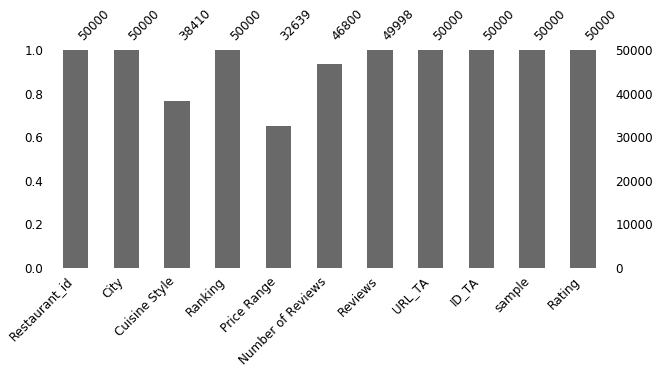

In [20]:
msno.bar(data, figsize=(10, 4),  fontsize=12);

Cuisine Style, Price Range и Number of Reviews содержат пропуски. Далее мы их заполним и создадим новые признаки, которые будут говорить об отсутствии информации.

# Restaurant_id — идентификационный номер ресторана / сети ресторанов

In [21]:
data.Restaurant_id.value_counts()

id_436      19
id_633      19
id_227      19
id_871      19
id_344      18
            ..
id_11692     1
id_13323     1
id_14100     1
id_10175     1
id_12848     1
Name: Restaurant_id, Length: 13094, dtype: int64

видно, что есть повторящиеся id, это скорее всего сетевые рестораны, поэтому создаем новый признак chain_restaurant: 1 - сетевой, 0 - несетевой.

In [22]:
chain_restaurant = list(data.Restaurant_id.value_counts()[data.Restaurant_id.value_counts() > 1].index)

In [23]:
data['chain'] = data[data.Restaurant_id.isin(chain_restaurant)].Restaurant_id.apply(lambda x: 1)
data['chain'].fillna(0, inplace=True)

In [24]:
data['chain'].value_counts()

1.0    46193
0.0     3807
Name: chain, dtype: int64

In [25]:
data.shape

(50000, 12)

# City - город, в котором находится ресторан

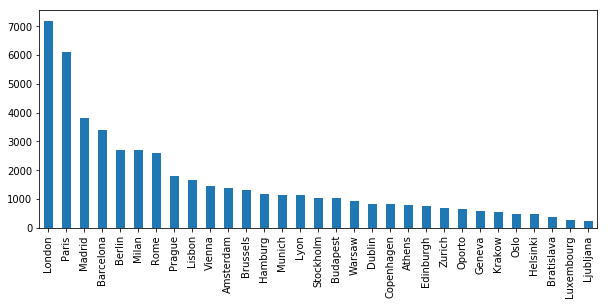

In [26]:
plt.figure(figsize=(10,4))
data.City.value_counts(ascending=False).plot(kind='bar');

Создадим список городов и найдем в добавленом датасете эти города.

In [27]:
data.loc[data.City == 'Oporto', 'City'] = 'Porto'
city_lst = data.City.unique()

In [28]:
data['ranked_cities'] = data['City'].rank()

In [29]:
df_city = df_city[(df_city.city_ascii.isin(city_lst)) &
                  (df_city.country != 'United States') &
                  (df_city.country != 'Canada') &
                  (df_city.country != 'Venezuela')]

In [30]:
set(city_lst) - set(df_city.city_ascii) # проверка все ли города нашли

set()

Удалим ненужные колонки, заменим пропуски и переведем численость в млн. человек. Признак столица заменим числовыми значениями на 0 и 1

In [31]:
df_city = df_city.drop(['city', 'iso2', 'iso3', 'admin_name',  'id'], axis=1)

In [32]:
df_city['population']  = round((df_city['population'] / 1000000), 2)

In [33]:
df_city.capital.fillna('primary', inplace=True)

In [34]:
df_city['capital'] = df_city.capital.apply(lambda x: 1 if x == 'primary' else 0)

In [35]:
df_city = df_city.reset_index(drop = True).head(31)
df_city

,city_ascii,lat,lng,country,capital,population
0,Paris,48.8566,2.3522,France,1,11.02
1,London,51.5072,-0.1275,United Kingdom,1,10.98
2,Madrid,40.4167,-3.7167,Spain,1,6.03
3,Barcelona,41.3825,2.1769,Spain,0,4.59
4,Berlin,52.5167,13.3833,Germany,1,3.64
5,Rome,41.8931,12.4828,Italy,1,2.87
6,Vienna,48.2083,16.3731,Austria,1,1.91
7,Hamburg,53.5500,10.0000,Germany,0,1.84
8,Warsaw,52.2167,21.0333,Poland,1,1.79
9,Brussels,50.8333,4.3333,Belgium,1,1.74


In [36]:
data = pd.merge(data, df_city, left_on='City', right_on = 'city_ascii', how = 'left')

In [37]:
data.shape

(50000, 19)

Создаем признак количество ресторанов в городе

In [38]:
city_counts_dict = dict(data['City'].value_counts())

In [39]:
data['rest_counts'] = data.City.map(city_counts_dict)

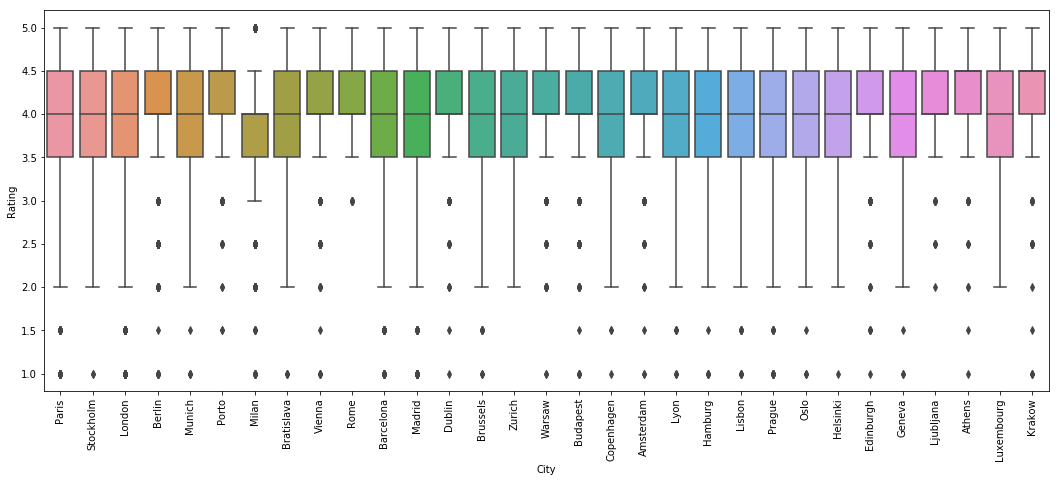

In [40]:
plt.figure(figsize=(18, 7))
sns.boxplot(x='City', y='Rating', data=data[data['sample'] == 1])
plt.xticks(rotation=90);

In [41]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,chain,ranked_cities,city_ascii,lat,lng,country,capital,population,rest_counts
23362,id_3932,Paris,"['French', 'European', 'Cafe']",3933.0,$$ - $$$,55.0,"[['Cake and Sandwiches', 'Hands down the best ...",/Restaurant_Review-g187147-d8020843-Reviews-Pa...,d8020843,1,4.0,1.0,37813.5,Paris,48.8566,2.3522,France,1,11.02,6108
33803,id_5484,Paris,"['French', 'European', 'Gastropub']",5485.0,$$ - $$$,76.0,"[['Waiter was a Character', 'Nice traditional ...",/Restaurant_Review-g187147-d719218-Reviews-Au_...,d719218,1,3.5,1.0,37813.5,Paris,48.8566,2.3522,France,1,11.02,6108
37325,id_1626,Copenhagen,['Contemporary'],1629.0,$$ - $$$,37.0,"[['Good choice before the opera', 'Disappointi...",/Restaurant_Review-g189541-d4127702-Reviews-Bo...,d4127702,1,4.0,1.0,11373.0,Copenhagen,55.6761,12.5689,Denmark,1,0.60,819
3914,id_3914,London,"['Bar', 'British', 'Pub']",3847.0,$$ - $$$,83.0,"[['Old School Boozer...', 'PROPER BAR'], ['12/...",/Restaurant_Review-g186338-d3953749-Reviews-Th...,d3953749,0,0.0,1.0,21634.0,London,51.5072,-0.1275,United Kingdom,1,10.98,7193
12474,id_6291,Madrid,"['European', 'Spanish']",6294.0,$$$$,22.0,"[['The OLIVES!!', 'Muy caro'], ['11/19/2017', ...",/Restaurant_Review-g187514-d12858177-Reviews-R...,d12858177,1,3.5,1.0,28526.0,Madrid,40.4167,-3.7167,Spain,1,6.03,3813


# Cuisine Style - кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане

In [42]:
data['Cuisine Style'][0]

"['Bar', 'Pub']"

видим, что значения представлены в виде строки. Создадим список уникальных кухонь представленных во всем датасете. Пропуски заполним значением 'local_cuisine', создадим колонку, которая показывает было ли значение пустое.

In [43]:
data['Cuisine_Style_NAN'] = data['Cuisine Style'].isna().astype('uint8')
data['Cuisine Style'].fillna("['local_cuisine']", inplace=True)

In [44]:
data['Cuisine Style']

0                                           ['Bar', 'Pub']
1        ['European', 'Scandinavian', 'Gluten Free Opti...
2                                  ['Vegetarian Friendly']
3        ['Italian', 'Mediterranean', 'European', 'Vege...
4        ['Italian', 'Mediterranean', 'European', 'Seaf...
                               ...                        
49995    ['Italian', 'Vegetarian Friendly', 'Vegan Opti...
49996    ['French', 'American', 'Bar', 'European', 'Veg...
49997                                ['Japanese', 'Sushi']
49998    ['Polish', 'European', 'Eastern European', 'Ce...
49999                                          ['Spanish']
Name: Cuisine Style, Length: 50000, dtype: object

In [45]:
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: eval(x))

In [46]:
data['cuisine_count'] = data['Cuisine Style'].apply(lambda x: len(x))

Посмотрим частоту встречаемости кухонь и выберем редкие (< 50)

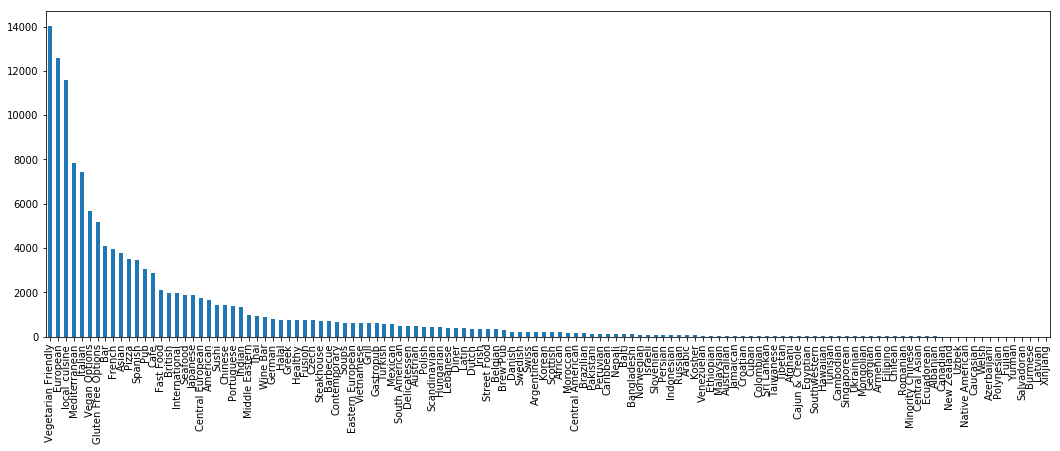

In [47]:
plt.figure(figsize=(18,6))
data.explode('Cuisine Style')['Cuisine Style'].value_counts(ascending=False).plot(kind='bar');

Кухни vegetarian friendly и european самые популярные. Создадим список популярных кухонь, которые встречаются больше 50 раз

In [48]:
cuisine_popular_lst = data.explode('Cuisine Style')['Cuisine Style'].value_counts()[
    data.explode('Cuisine Style')['Cuisine Style'].value_counts() > 50].index.tolist()

In [49]:
def cuisine_popular_count(cell):
    '''Количество популярных кухонь в ресторане'''
    x = 0
    for i in cuisine_popular_lst:
        if i in cell:
            x += 1
    return x

In [50]:
data['cuisine_popular'] = data['Cuisine Style'].apply(cuisine_popular_count)

Создадим dummy переменные кухонь

In [51]:
data

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,city_ascii,lat,lng,country,capital,population,rest_counts,Cuisine_Style_NAN,cuisine_count,cuisine_popular
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,Paris,48.8566,2.3522,France,1,11.02,6108,0,2,2
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,Helsinki,60.1756,24.9342,Finland,1,0.64,475,0,5,5
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,Edinburgh,55.9530,-3.1890,United Kingdom,1,0.49,745,0,1,1
3,id_3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,London,51.5072,-0.1275,United Kingdom,1,10.98,7193,0,5,5
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,Bratislava,48.1447,17.1128,Slovakia,1,0.43,380,0,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,...,Milan,45.4669,9.1900,Italy,0,1.37,2694,0,4,4
49996,id_6340,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,...,Paris,48.8566,2.3522,France,1,11.02,6108,0,5,5
49997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,...,Stockholm,59.3294,18.0686,Sweden,1,0.97,1033,0,2,2
49998,id_640,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,...,Warsaw,52.2167,21.0333,Poland,1,1.79,925,0,5,5


In [52]:
#cuisine_lst = data.explode('Cuisine Style')['Cuisine Style'].value_counts().head(20).index

In [53]:
#def find_item(cell):
#    if item in cell:
#        return 1
#    return 0
    
#for item in cuisine_lst:
#    data[item] = data['Cuisine Style'].apply(find_item)

In [54]:
data.shape

(50000, 23)

# Ranking - место, которое занимает данный ресторан среди всех ресторанов своего города

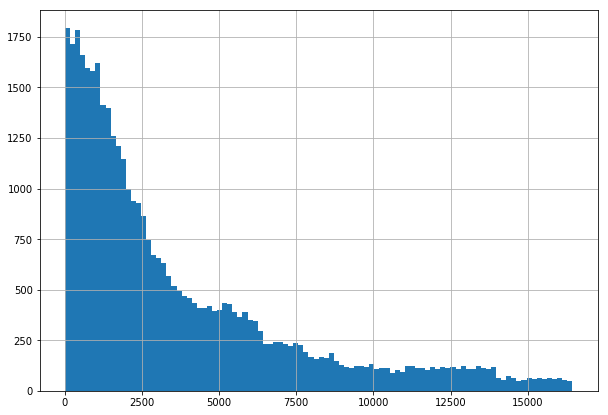

In [55]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе

посмотрим на топ 10 городов


In [56]:
(data['City'].value_counts())[0:10].index

Index(['London', 'Paris', 'Madrid', 'Barcelona', 'Berlin', 'Milan', 'Rome',
       'Prague', 'Lisbon', 'Vienna'],
      dtype='object')

In [57]:
(data['City'].value_counts()).sum()

50000

In [58]:
data['Ranking'][data['City'] == 'Madrid']

25       5828.0
30       2418.0
55       6819.0
86       3489.0
111      6666.0
          ...  
49892    2324.0
49904    3353.0
49923    5662.0
49954     681.0
49986    7279.0
Name: Ranking, Length: 3813, dtype: float64

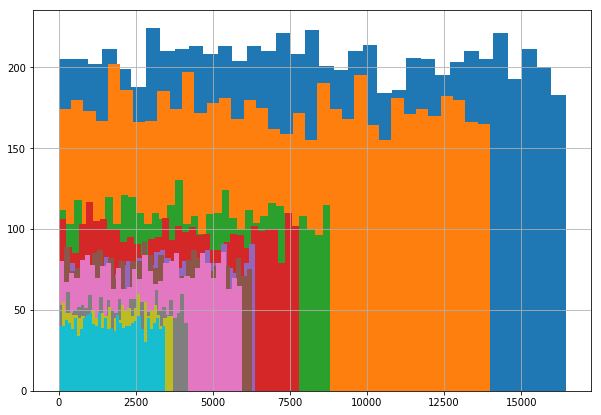

In [59]:
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=35)

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.


Разделим Ranking на количество ресторанов в городе

In [60]:
data['ranking_norm'] = data.Ranking / data.rest_counts

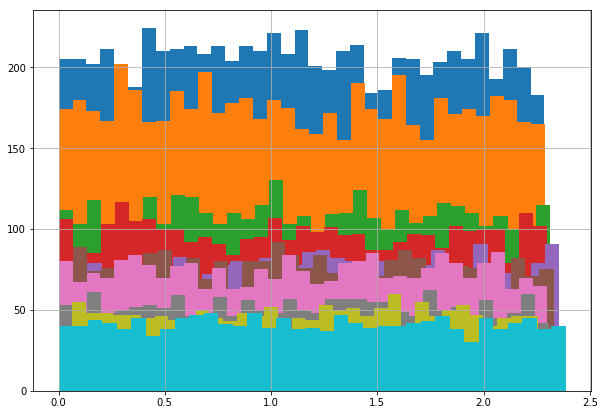

In [61]:
for x in (data['City'].value_counts())[0:10].index:
    data['ranking_norm'][data['City'] == x].hist(bins=35)

Вычисляем относительную позицию ресторана среди всех ресторанов города

In [62]:
def get_Weighed_Rank_RK(row):

    Weighed_Rank = row['Ranking'] / row['Restaurants Count']

    return Weighed_Rank

In [63]:
def get_Weighed_Rank(row):
    i=0
    city_min = CityMinMax[CityMinMax['City'] == row.City ]['min'].iloc[0]
    city_max = CityMinMax[CityMinMax['City'] == row.City ]['max'].iloc[0]
    Weighed_Rank = round(1-(row['Ranking'] - city_min)/(city_max - city_min),3)
    return Weighed_Rank

Вычисляем к-во ресторанов для города в каждой строке

In [64]:
restorants_in_city = data.groupby('City')['Ranking'].count().to_dict()
data['Restaurants Count'] = data['City'].map(restorants_in_city)

Получаем относительную позицию ресторана среди всех ресторанов города

In [65]:

data['Weighed Rank'] = data.apply(lambda x: get_Weighed_Rank_RK(x), axis=1)

CityMinMax =data.groupby('City')['Ranking'].agg([min,max])
CityMinMax =CityMinMax.reset_index()
data['Weighed Rank min max'] = data.apply(lambda x: get_Weighed_Rank(x), axis=1)

# Rating - рейтинг ресторана по данным TripAdvisor, целевая переменная

### Посмотрим распределение целевой переменной

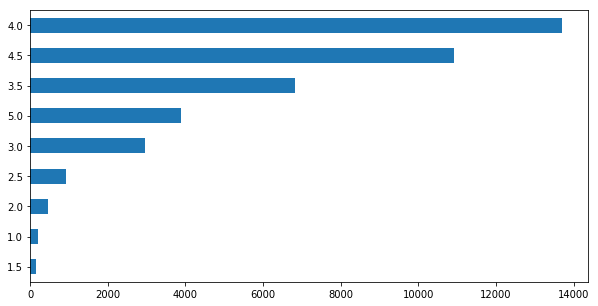

In [66]:
plt.figure(figsize=(10, 5))
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

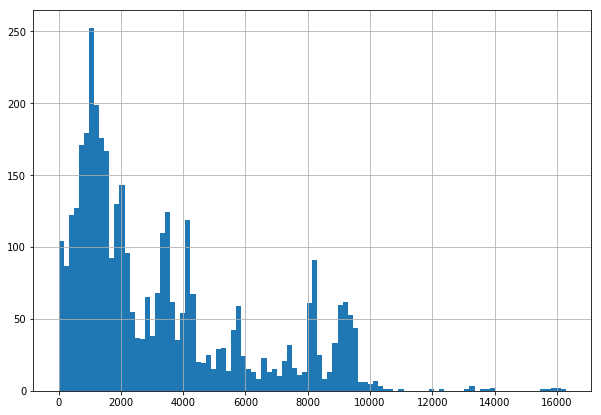

In [67]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

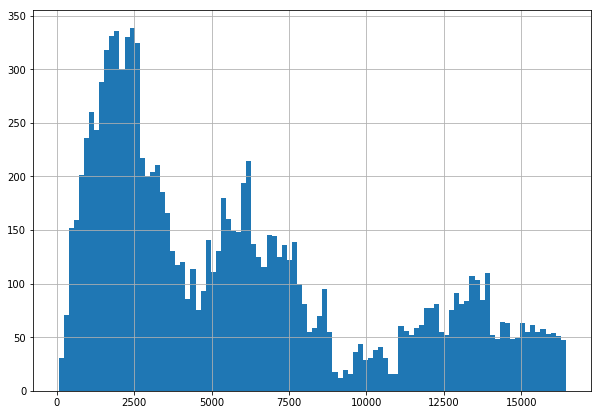

In [68]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

Корреляция имеющихся признаков - практически единственным признаком, коррелирующим с Rating является Ranking. Он, в свою очередь, уже имеет слабую корреляцию практически со всеми признаками

# Price Range - диапазон цен в ресторане

Заменим пропуски и изменим значения от 1 до 3. Создадим признак отсутствия информации.

In [69]:
data['Price Range'].value_counts(dropna=False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [70]:
data['Price Range_NAN'] = data['Price Range'].isna().astype('uint8')

In [71]:
data['Price Range'].fillna(data['Price Range'].mode()[0], inplace=True)

In [72]:
price_dict = {'$': 1,
              '$$ - $$$': 2,
              '$$$$': 3}

In [73]:
data['Price Range'] = data['Price Range'].map(price_dict)

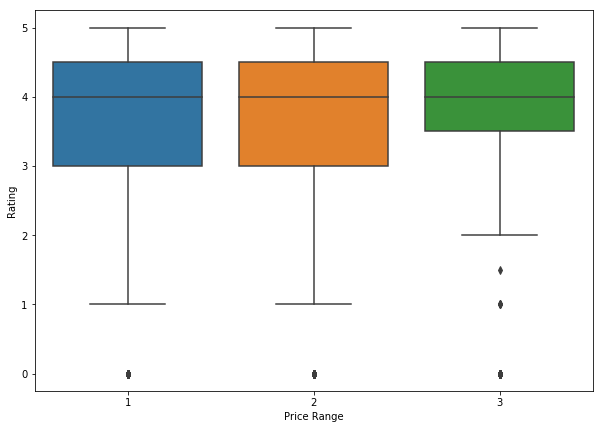

In [74]:
sns.boxplot(x='Price Range', y='Rating', data=data);

Рестораны с большим рейтингом более дорогие

# Reviews - данные о двух отзывах, которые отображаются на сайте ресторана

из строки Reviews получаем 4 столбца, 2 с отзывами и 2 с датами этих отзывов

In [75]:
lrx = re.compile('\[\[.*\]\]')
nan = None

def review_extraction(row):
    cell = row['Reviews']
    aux_list = [[], []]  
    if type(cell) == str and lrx.fullmatch(cell): 
        aux_list = eval(cell)  

    row['reviews_txt1'] = aux_list[0][1] if len(aux_list[0]) > 1 else nan
    row['reviews_txt2'] = aux_list[0][0] if len(aux_list[0]) > 0 else nan

    row['reviews_data1'] = pd.to_datetime(
        aux_list[1][1] if len(aux_list[1]) > 1 else nan)
    row['reviews_data2'] = pd.to_datetime(aux_list[1][0] if len(
        aux_list[1]) > 0 else nan, format='%m/%d/%Y', errors='coerce')

    row['reviews_data1'] = pd.to_datetime(row['reviews_data1'])
    row['reviews_data2'] = pd.to_datetime(row['reviews_data2'])

    return row

In [76]:
data = data.apply(review_extraction, axis=1)

Так как тональность текста еще не умею обрабатывать, то удаляем этот столбец

In [77]:
data.drop('reviews_txt1', axis=1, inplace=True)
data.drop('reviews_txt2', axis=1, inplace=True)

Создадим признак разницы дней между последними двумя отзывами.

In [78]:
def get_days(timedelta):
    return timedelta.days

data['rewiew_days'] = data['reviews_data2'] - data['reviews_data1']
data['rewiew_days'] = data['rewiew_days'].apply(get_days)

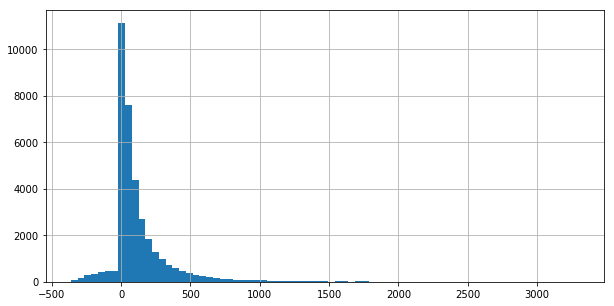

In [79]:
plt.figure(figsize=(10,5))
data['rewiew_days'].hist(bins=75);

In [80]:
data['days_to_now'] = (datetime.now() - data['reviews_data2']).dt.days
data['days_to_now']

0           NaN
1        1373.0
2        1350.0
3        1372.0
4        1308.0
          ...  
49995    1362.0
49996    1357.0
49997    1770.0
49998    1520.0
49999    2047.0
Name: days_to_now, Length: 50000, dtype: float64

Создадим признак количества последних коментариев (0-2)

In [81]:
data['Reviews_cnt'] = 2 - data[['reviews_data1', 'reviews_data2']].isnull().sum(axis = 1)
data

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,ranking_norm,Restaurants Count,Weighed Rank,Weighed Rank min max,Price Range_NAN,reviews_data1,reviews_data2,rewiew_days,days_to_now,Reviews_cnt
0,id_0,Paris,"[Bar, Pub]",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,2.122299,6108,2.122299,0.073,0,NaT,NaT,NaN,NaN,0
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0.223158,475,0.223158,0.910,0,2017-10-29,2017-12-05,37.0,1373.0,2
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,1.087248,745,1.087248,0.542,0,2017-12-06,2017-12-28,22.0,1350.0,2
3,id_3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,0.232031,7193,0.232031,0.899,0,2017-11-22,2017-12-06,14.0,1372.0,2
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,0.097368,380,0.097368,0.962,0,2018-01-24,2018-02-08,15.0,1308.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,2,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,...,0.185598,2694,0.185598,0.920,0,2017-11-12,2017-12-16,34.0,1362.0,2
49996,id_6340,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,...,1.038147,6108,1.038147,0.547,0,2017-12-12,2017-12-21,9.0,1357.0,2
49997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,2,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,...,1.599226,1033,1.599226,0.330,1,2008-04-12,2016-11-03,3127.0,1770.0,2
49998,id_640,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,...,0.692973,925,0.692973,0.703,0,2017-06-18,2017-07-11,23.0,1520.0,2


# Number of Reviews - количество отзывов о ресторане

создаем новый признак количество отзывов на человека

In [82]:
data['Reviews_for_person'] = data['Number of Reviews'] / (data['population'] + 1)

In [83]:
# data[data['last_rewiew_counts'] ==0][['Number of Reviews', 'last_rewiew_counts']].head()

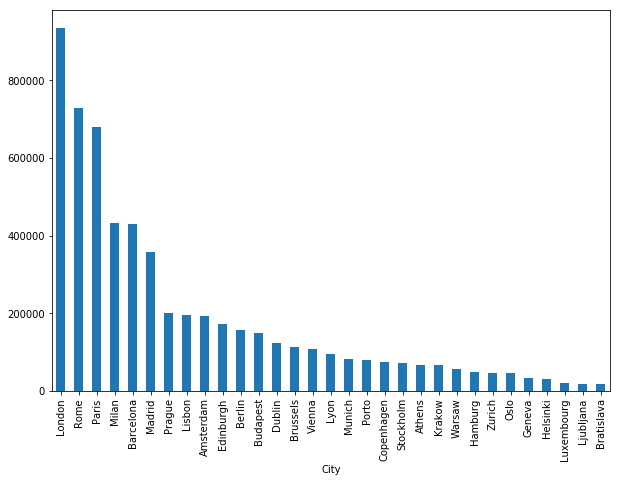

In [84]:
data.groupby('City')['Number of Reviews'].sum().sort_values(ascending=False).plot(kind='bar');

In [85]:
rewiews_city_dict = dict(data.groupby('City')['Number of Reviews'].sum())

In [86]:
data['num_rewiews_city'] = data.City.map(rewiews_city_dict)

Создадим признак отношения рейтинга в городе к количеству отзывов в городе.

In [87]:
data['relative_rank_reviews'] = data['Ranking'] / data['num_rewiews_city']

# URL_TA - URL страницы ресторана на TripAdvisor

С ссылами пока не умею ничего делать, поэтому удалим столбец

In [88]:
data.drop(['URL_TA'], axis=1, inplace=True)

# ID_TA - идентификатор ресторана в базе данных TripAdvisor

Думаю, что этот признак никак не будет влиять на нашу модель, поэтому удаляем его

In [89]:
data.drop(['ID_TA'], axis=1, inplace=True)

**Удалим все нечисловые признаки и признаки, которые нам не нужны**

In [90]:
pd.set_option('display.max_columns', 200)
data


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,sample,Rating,chain,ranked_cities,city_ascii,lat,lng,country,capital,population,rest_counts,Cuisine_Style_NAN,cuisine_count,cuisine_popular,ranking_norm,Restaurants Count,Weighed Rank,Weighed Rank min max,Price Range_NAN,reviews_data1,reviews_data2,rewiew_days,days_to_now,Reviews_cnt,Reviews_for_person,num_rewiews_city,relative_rank_reviews
0,id_0,Paris,"[Bar, Pub]",12963.0,2,4.0,"[[], []]",0,0.0,1.0,37813.5,Paris,48.8566,2.3522,France,1,11.02,6108,0,2,2,2.122299,6108,2.122299,0.073,0,NaT,NaT,NaN,NaN,0,0.332779,680827.0,0.019040
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,1.0,15377.0,Helsinki,60.1756,24.9342,Finland,1,0.64,475,0,5,5,0.223158,475,0.223158,0.910,0,2017-10-29,2017-12-05,37.0,1373.0,2,59.146341,29511.0,0.003592
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,0.0,1.0,12991.0,Edinburgh,55.9530,-3.1890,United Kingdom,1,0.49,745,0,1,1,1.087248,745,1.087248,0.542,0,2017-12-06,2017-12-28,22.0,1350.0,2,18.791946,172103.0,0.004706
3,id_3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",0,0.0,1.0,21634.0,London,51.5072,-0.1275,United Kingdom,1,10.98,7193,0,5,5,0.232031,7193,0.232031,0.899,0,2017-11-22,2017-12-06,14.0,1372.0,2,16.861436,933770.0,0.001787
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",0,0.0,1.0,8438.5,Bratislava,48.1447,17.1128,Slovakia,1,0.43,380,0,6,6,0.097368,380,0.097368,0.962,0,2018-01-24,2018-02-08,15.0,1308.0,2,113.286713,16672.0,0.002219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,2,79.0,"[['The real Italian experience!', 'Wonderful f...",1,4.5,1.0,31779.5,Milan,45.4669,9.1900,Italy,0,1.37,2694,0,4,4,0.185598,2694,0.185598,0.920,0,2017-11-12,2017-12-16,34.0,1362.0,2,33.333333,431350.0,0.001159
49996,id_6340,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",1,3.5,1.0,37813.5,Paris,48.8566,2.3522,France,1,11.02,6108,0,5,5,1.038147,6108,1.038147,0.547,0,2017-12-12,2017-12-21,9.0,1357.0,2,45.091514,680827.0,0.009314
49997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,2,4.0,"[['Good by swedish standards', 'A hidden jewel...",1,4.5,1.0,46431.0,Stockholm,59.3294,18.0686,Sweden,1,0.97,1033,0,2,2,1.599226,1033,1.599226,0.330,1,2008-04-12,2016-11-03,3127.0,1770.0,2,2.030457,71588.0,0.023076
49998,id_640,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",1,4.0,1.0,48853.0,Warsaw,52.2167,21.0333,Poland,1,1.79,925,0,5,5,0.692973,925,0.692973,0.703,0,2017-06-18,2017-07-11,23.0,1520.0,2,25.089606,55636.0,0.011521


In [91]:
columns_to_drop = ['City', 'Cuisine Style', 'Reviews', 'country', 'reviews_data1', 'reviews_data2', 'city_ascii']

In [92]:
data.drop(columns_to_drop, axis=1, inplace = True)

In [93]:
data

,Restaurant_id,Ranking,Price Range,Number of Reviews,sample,Rating,chain,ranked_cities,lat,lng,capital,population,rest_counts,Cuisine_Style_NAN,cuisine_count,cuisine_popular,ranking_norm,Restaurants Count,Weighed Rank,Weighed Rank min max,Price Range_NAN,rewiew_days,days_to_now,Reviews_cnt,Reviews_for_person,num_rewiews_city,relative_rank_reviews
0,id_0,12963.0,2,4.0,0,0.0,1.0,37813.5,48.8566,2.3522,1,11.02,6108,0,2,2,2.122299,6108,2.122299,0.073,0,NaN,NaN,0,0.332779,680827.0,0.019040
1,id_1,106.0,2,97.0,0,0.0,1.0,15377.0,60.1756,24.9342,1,0.64,475,0,5,5,0.223158,475,0.223158,0.910,0,37.0,1373.0,2,59.146341,29511.0,0.003592
2,id_2,810.0,2,28.0,0,0.0,1.0,12991.0,55.9530,-3.1890,1,0.49,745,0,1,1,1.087248,745,1.087248,0.542,0,22.0,1350.0,2,18.791946,172103.0,0.004706
3,id_3,1669.0,3,202.0,0,0.0,1.0,21634.0,51.5072,-0.1275,1,10.98,7193,0,5,5,0.232031,7193,0.232031,0.899,0,14.0,1372.0,2,16.861436,933770.0,0.001787
4,id_4,37.0,3,162.0,0,0.0,1.0,8438.5,48.1447,17.1128,1,0.43,380,0,6,6,0.097368,380,0.097368,0.962,0,15.0,1308.0,2,113.286713,16672.0,0.002219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,500.0,2,79.0,1,4.5,1.0,31779.5,45.4669,9.1900,0,1.37,2694,0,4,4,0.185598,2694,0.185598,0.920,0,34.0,1362.0,2,33.333333,431350.0,0.001159
49996,id_6340,6341.0,2,542.0,1,3.5,1.0,37813.5,48.8566,2.3522,1,11.02,6108,0,5,5,1.038147,6108,1.038147,0.547,0,9.0,1357.0,2,45.091514,680827.0,0.009314
49997,id_1649,1652.0,2,4.0,1,4.5,1.0,46431.0,59.3294,18.0686,1,0.97,1033,0,2,2,1.599226,1033,1.599226,0.330,1,3127.0,1770.0,2,2.030457,71588.0,0.023076
49998,id_640,641.0,2,70.0,1,4.0,1.0,48853.0,52.2167,21.0333,1,1.79,925,0,5,5,0.692973,925,0.692973,0.703,0,23.0,1520.0,2,25.089606,55636.0,0.011521


In [94]:
data = data.fillna(0)

In [95]:
data

,Restaurant_id,Ranking,Price Range,Number of Reviews,sample,Rating,chain,ranked_cities,lat,lng,capital,population,rest_counts,Cuisine_Style_NAN,cuisine_count,cuisine_popular,ranking_norm,Restaurants Count,Weighed Rank,Weighed Rank min max,Price Range_NAN,rewiew_days,days_to_now,Reviews_cnt,Reviews_for_person,num_rewiews_city,relative_rank_reviews
0,id_0,12963.0,2,4.0,0,0.0,1.0,37813.5,48.8566,2.3522,1,11.02,6108,0,2,2,2.122299,6108,2.122299,0.073,0,0.0,0.0,0,0.332779,680827.0,0.019040
1,id_1,106.0,2,97.0,0,0.0,1.0,15377.0,60.1756,24.9342,1,0.64,475,0,5,5,0.223158,475,0.223158,0.910,0,37.0,1373.0,2,59.146341,29511.0,0.003592
2,id_2,810.0,2,28.0,0,0.0,1.0,12991.0,55.9530,-3.1890,1,0.49,745,0,1,1,1.087248,745,1.087248,0.542,0,22.0,1350.0,2,18.791946,172103.0,0.004706
3,id_3,1669.0,3,202.0,0,0.0,1.0,21634.0,51.5072,-0.1275,1,10.98,7193,0,5,5,0.232031,7193,0.232031,0.899,0,14.0,1372.0,2,16.861436,933770.0,0.001787
4,id_4,37.0,3,162.0,0,0.0,1.0,8438.5,48.1447,17.1128,1,0.43,380,0,6,6,0.097368,380,0.097368,0.962,0,15.0,1308.0,2,113.286713,16672.0,0.002219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,500.0,2,79.0,1,4.5,1.0,31779.5,45.4669,9.1900,0,1.37,2694,0,4,4,0.185598,2694,0.185598,0.920,0,34.0,1362.0,2,33.333333,431350.0,0.001159
49996,id_6340,6341.0,2,542.0,1,3.5,1.0,37813.5,48.8566,2.3522,1,11.02,6108,0,5,5,1.038147,6108,1.038147,0.547,0,9.0,1357.0,2,45.091514,680827.0,0.009314
49997,id_1649,1652.0,2,4.0,1,4.5,1.0,46431.0,59.3294,18.0686,1,0.97,1033,0,2,2,1.599226,1033,1.599226,0.330,1,3127.0,1770.0,2,2.030457,71588.0,0.023076
49998,id_640,641.0,2,70.0,1,4.0,1.0,48853.0,52.2167,21.0333,1,1.79,925,0,5,5,0.692973,925,0.692973,0.703,0,23.0,1520.0,2,25.089606,55636.0,0.011521


# корреляция признаков


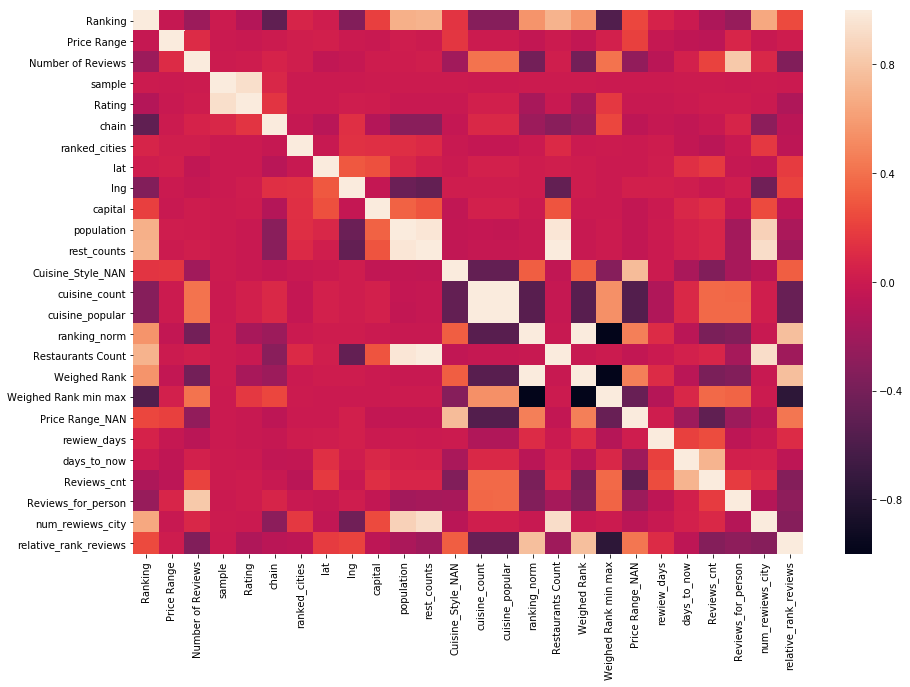

In [96]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.corr())

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [97]:
# # на всякий случай, заново подгружаем данные
# df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
# df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
# df_train['sample'] = 1 # помечаем где у нас трейн
# df_test['sample'] = 0 # помечаем где у нас тест
# df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

# data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
# data.info()

#### Запускаем и проверяем что получилось

In [98]:
# df_preproc = preproc_data(data)
# df_preproc.sample(10)

In [99]:
# df_preproc.info()

In [100]:
data['Reviews_for_person'] = data['Number of Reviews'] / (data['population'] + 1)

In [101]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating', 'Restaurant_id'], axis=1)

In [102]:
train_data

,Restaurant_id,Ranking,Price Range,Number of Reviews,Rating,chain,ranked_cities,lat,lng,capital,population,rest_counts,Cuisine_Style_NAN,cuisine_count,cuisine_popular,ranking_norm,Restaurants Count,Weighed Rank,Weighed Rank min max,Price Range_NAN,rewiew_days,days_to_now,Reviews_cnt,Reviews_for_person,num_rewiews_city,relative_rank_reviews
10000,id_5569,5570.0,2,194.0,3.5,1.0,37813.5,48.8566,2.3522,1,11.02,6108,0,3,3,0.911919,6108,0.911919,0.602,0,41.0,1347.0,2,16.139767,680827.0,0.008181
10001,id_1535,1537.0,2,10.0,4.0,1.0,46431.0,59.3294,18.0686,1,0.97,1033,1,1,1,1.487899,1033,1.487899,0.376,1,382.0,1525.0,2,5.076142,71588.0,0.021470
10002,id_352,353.0,3,688.0,4.5,1.0,21634.0,51.5072,-0.1275,1,10.98,7193,0,7,7,0.049075,7193,0.049075,0.979,0,2.0,1339.0,2,57.429048,933770.0,0.000378
10003,id_3456,3458.0,2,3.0,5.0,1.0,6896.0,52.5167,13.3833,1,3.64,2705,1,1,1,1.278373,2705,1.278373,0.457,1,0.0,0.0,0,0.646552,155923.0,0.022178
10004,id_615,621.0,2,84.0,4.0,1.0,33699.0,48.1372,11.5755,0,1.47,1145,0,3,3,0.542358,1145,0.542358,0.776,0,272.0,1390.0,2,34.008097,82386.0,0.007538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,500.0,2,79.0,4.5,1.0,31779.5,45.4669,9.1900,0,1.37,2694,0,4,4,0.185598,2694,0.185598,0.920,0,34.0,1362.0,2,33.333333,431350.0,0.001159
49996,id_6340,6341.0,2,542.0,3.5,1.0,37813.5,48.8566,2.3522,1,11.02,6108,0,5,5,1.038147,6108,1.038147,0.547,0,9.0,1357.0,2,45.091514,680827.0,0.009314
49997,id_1649,1652.0,2,4.0,4.5,1.0,46431.0,59.3294,18.0686,1,0.97,1033,0,2,2,1.599226,1033,1.599226,0.330,1,3127.0,1770.0,2,2.030457,71588.0,0.023076
49998,id_640,641.0,2,70.0,4.0,1.0,48853.0,52.2167,21.0333,1,1.79,925,0,5,5,0.692973,925,0.692973,0.703,0,23.0,1520.0,2,25.089606,55636.0,0.011521


In [103]:
test_data

,Restaurant_id,Ranking,Price Range,Number of Reviews,Rating,chain,ranked_cities,lat,lng,capital,population,rest_counts,Cuisine_Style_NAN,cuisine_count,cuisine_popular,ranking_norm,Restaurants Count,Weighed Rank,Weighed Rank min max,Price Range_NAN,rewiew_days,days_to_now,Reviews_cnt,Reviews_for_person,num_rewiews_city,relative_rank_reviews
0,id_0,12963.0,2,4.0,0.0,1.0,37813.5,48.8566,2.3522,1,11.02,6108,0,2,2,2.122299,6108,2.122299,0.073,0,0.0,0.0,0,0.332779,680827.0,0.019040
1,id_1,106.0,2,97.0,0.0,1.0,15377.0,60.1756,24.9342,1,0.64,475,0,5,5,0.223158,475,0.223158,0.910,0,37.0,1373.0,2,59.146341,29511.0,0.003592
2,id_2,810.0,2,28.0,0.0,1.0,12991.0,55.9530,-3.1890,1,0.49,745,0,1,1,1.087248,745,1.087248,0.542,0,22.0,1350.0,2,18.791946,172103.0,0.004706
3,id_3,1669.0,3,202.0,0.0,1.0,21634.0,51.5072,-0.1275,1,10.98,7193,0,5,5,0.232031,7193,0.232031,0.899,0,14.0,1372.0,2,16.861436,933770.0,0.001787
4,id_4,37.0,3,162.0,0.0,1.0,8438.5,48.1447,17.1128,1,0.43,380,0,6,6,0.097368,380,0.097368,0.962,0,15.0,1308.0,2,113.286713,16672.0,0.002219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,id_9995,4367.0,1,28.0,0.0,1.0,21634.0,51.5072,-0.1275,1,10.98,7193,0,4,3,0.607118,7193,0.607118,0.734,0,122.0,1364.0,2,2.337229,933770.0,0.004677
9996,id_9996,2612.0,2,2.0,0.0,0.0,16992.0,38.7452,-9.1604,1,0.51,1647,0,4,4,1.585914,1647,1.585914,0.297,0,0.0,1383.0,1,1.324503,196347.0,0.013303
9997,id_9997,5562.0,2,2.0,0.0,0.0,31779.5,45.4669,9.1900,0,1.37,2694,1,1,1,2.064588,2694,2.064588,0.114,1,0.0,0.0,0,0.843882,431350.0,0.012894
9998,id_9998,4010.0,2,2.0,0.0,0.0,31779.5,45.4669,9.1900,0,1.37,2694,0,1,1,1.488493,2694,1.488493,0.361,1,0.0,0.0,0,0.843882,431350.0,0.009296


In [104]:
X

,Ranking,Price Range,Number of Reviews,chain,ranked_cities,lat,lng,capital,population,rest_counts,Cuisine_Style_NAN,cuisine_count,cuisine_popular,ranking_norm,Restaurants Count,Weighed Rank,Weighed Rank min max,Price Range_NAN,rewiew_days,days_to_now,Reviews_cnt,Reviews_for_person,num_rewiews_city,relative_rank_reviews
10000,5570.0,2,194.0,1.0,37813.5,48.8566,2.3522,1,11.02,6108,0,3,3,0.911919,6108,0.911919,0.602,0,41.0,1347.0,2,16.139767,680827.0,0.008181
10001,1537.0,2,10.0,1.0,46431.0,59.3294,18.0686,1,0.97,1033,1,1,1,1.487899,1033,1.487899,0.376,1,382.0,1525.0,2,5.076142,71588.0,0.021470
10002,353.0,3,688.0,1.0,21634.0,51.5072,-0.1275,1,10.98,7193,0,7,7,0.049075,7193,0.049075,0.979,0,2.0,1339.0,2,57.429048,933770.0,0.000378
10003,3458.0,2,3.0,1.0,6896.0,52.5167,13.3833,1,3.64,2705,1,1,1,1.278373,2705,1.278373,0.457,1,0.0,0.0,0,0.646552,155923.0,0.022178
10004,621.0,2,84.0,1.0,33699.0,48.1372,11.5755,0,1.47,1145,0,3,3,0.542358,1145,0.542358,0.776,0,272.0,1390.0,2,34.008097,82386.0,0.007538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,500.0,2,79.0,1.0,31779.5,45.4669,9.1900,0,1.37,2694,0,4,4,0.185598,2694,0.185598,0.920,0,34.0,1362.0,2,33.333333,431350.0,0.001159
49996,6341.0,2,542.0,1.0,37813.5,48.8566,2.3522,1,11.02,6108,0,5,5,1.038147,6108,1.038147,0.547,0,9.0,1357.0,2,45.091514,680827.0,0.009314
49997,1652.0,2,4.0,1.0,46431.0,59.3294,18.0686,1,0.97,1033,0,2,2,1.599226,1033,1.599226,0.330,1,3127.0,1770.0,2,2.030457,71588.0,0.023076
49998,641.0,2,70.0,1.0,48853.0,52.2167,21.0333,1,1.79,925,0,5,5,0.692973,925,0.692973,0.703,0,23.0,1520.0,2,25.089606,55636.0,0.011521


**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [105]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [106]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 26), (40000, 26), (40000, 24), (32000, 24), (8000, 24))

# Model 
Сам ML

In [107]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [108]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [109]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [110]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19670062499999996


In [111]:
# MAE: 0.19778625

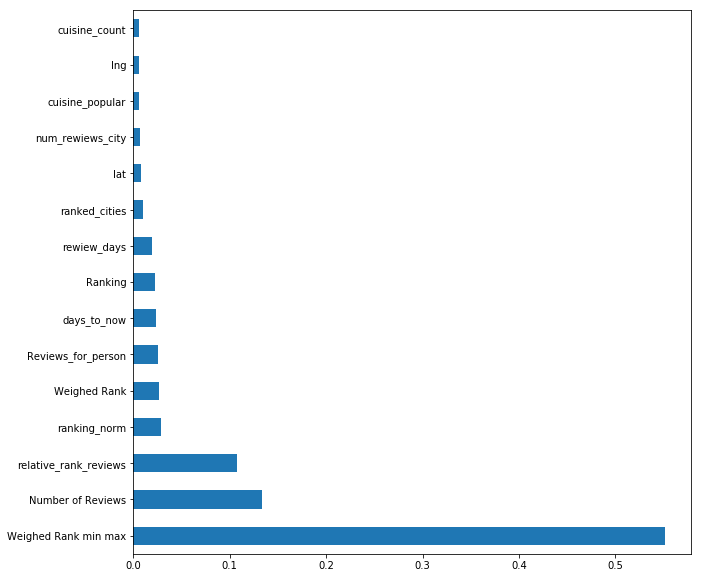

In [112]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [113]:
test_data

,Restaurant_id,Ranking,Price Range,Number of Reviews,Rating,chain,ranked_cities,lat,lng,capital,population,rest_counts,Cuisine_Style_NAN,cuisine_count,cuisine_popular,ranking_norm,Restaurants Count,Weighed Rank,Weighed Rank min max,Price Range_NAN,rewiew_days,days_to_now,Reviews_cnt,Reviews_for_person,num_rewiews_city,relative_rank_reviews
0,id_0,12963.0,2,4.0,0.0,1.0,37813.5,48.8566,2.3522,1,11.02,6108,0,2,2,2.122299,6108,2.122299,0.073,0,0.0,0.0,0,0.332779,680827.0,0.019040
1,id_1,106.0,2,97.0,0.0,1.0,15377.0,60.1756,24.9342,1,0.64,475,0,5,5,0.223158,475,0.223158,0.910,0,37.0,1373.0,2,59.146341,29511.0,0.003592
2,id_2,810.0,2,28.0,0.0,1.0,12991.0,55.9530,-3.1890,1,0.49,745,0,1,1,1.087248,745,1.087248,0.542,0,22.0,1350.0,2,18.791946,172103.0,0.004706
3,id_3,1669.0,3,202.0,0.0,1.0,21634.0,51.5072,-0.1275,1,10.98,7193,0,5,5,0.232031,7193,0.232031,0.899,0,14.0,1372.0,2,16.861436,933770.0,0.001787
4,id_4,37.0,3,162.0,0.0,1.0,8438.5,48.1447,17.1128,1,0.43,380,0,6,6,0.097368,380,0.097368,0.962,0,15.0,1308.0,2,113.286713,16672.0,0.002219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,id_9995,4367.0,1,28.0,0.0,1.0,21634.0,51.5072,-0.1275,1,10.98,7193,0,4,3,0.607118,7193,0.607118,0.734,0,122.0,1364.0,2,2.337229,933770.0,0.004677
9996,id_9996,2612.0,2,2.0,0.0,0.0,16992.0,38.7452,-9.1604,1,0.51,1647,0,4,4,1.585914,1647,1.585914,0.297,0,0.0,1383.0,1,1.324503,196347.0,0.013303
9997,id_9997,5562.0,2,2.0,0.0,0.0,31779.5,45.4669,9.1900,0,1.37,2694,1,1,1,2.064588,2694,2.064588,0.114,1,0.0,0.0,0,0.843882,431350.0,0.012894
9998,id_9998,4010.0,2,2.0,0.0,0.0,31779.5,45.4669,9.1900,0,1.37,2694,0,1,1,1.488493,2694,1.488493,0.361,1,0.0,0.0,0,0.843882,431350.0,0.009296


In [114]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [115]:
predict_submission = model.predict(test_data.drop(['Rating', 'Restaurant_id'], axis=1))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [116]:
predict_submission

array([3.055, 4.26 , 4.505, ..., 3.07 , 4.47 , 4.385])

In [117]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.055
1,id_1,4.260
2,id_2,4.505
3,id_3,4.245
4,id_4,4.395
5,id_5,4.385
6,id_6,1.715
7,id_7,2.785
8,id_8,4.070
9,id_9,4.705


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
